# Lab 3 - Visualization

Last update: 11/11/2023

- Name: Nguyễn Phát Đạt
- Student ID: 21127240

***

## Work and submission guidelines

**Work on your assignment**

- You need to do your assignment directly in this notebook. First, fill out your name and ID at the beginning of the file. In the notebook, fill in places that say:
```python
#TODO
```

- During your work, you can print out the result, create more cells to test, or create more functions to handle things. Please note that <font color=red>you are not allowed to delete or modify my code cells</font> (except in the case that mentioned above). Remember to remove `raise NotImplementedError("not implement")` when running the code.

- Always press `Ctrl + S` in order to save your work.

**Notes:**

    *  Copy means zero
    *  You have to submit your work on time. No exception
    *  Any questions about your grade are based on the assignment submitted on Moodle
    *  Wrong submission takes you -2 points

**Submit your work**

- When grading your assignment, I will choose `Kernel` - `Restart Kernel & Run All Cells` in order to restart the kernel and run all cells in your notebook. Therefore, you should do that before submitting to ensure that the outputs are all as expected.

- After that, rename you notebook with your student ID (e.g. `1234567.ipynb`) and submit on Moodle.

- <font color=red>Please strictly follow the submission rules.</font>

## Abstract and general requirements

**Abstract**

- In this assignment, you are required to visualize data and results. This task is very important since it provides reader (your clients, your boss,...) an overview of the data as well as your results.

- You will visualize the data in order to answer some questions. By answering these questions, you are able to get some insights from data.

- You will also visualize the results of machine learning model to be able to know whether your model works well or not.

**General requirements**

- Every charts **must have their own name, axes name, legends**.
- The charts you draw must not only be correct but also beautiful:
    - The correctness is shown in choosing the right chart and accurately calculating the data to draw the chart.
    - The beauty is expressed in the UI/UX of the chart. The beauty of UI is shown in choosing the colors, layout of the chart. The beauty of UX is reflected in the fact that the reader can easily capture your message conveyed through your notebook.

---

In [37]:
# visialize stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import json
# !pip install geopandas
import geopandas

# modeling stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

## Data visualization

- In this section, you are going to compute and visualize some information about Covid-19
- The data prepared in `./data` was collected from Worldometer
- Link: https://www.worldometers.info/coronavirus/

In [38]:
# read the data into a dataframe
df = pd.read_csv('./data/data.csv')
print(f'Shape: {df.shape}')
df.head(5)

Shape: (219, 10)


,Country Name,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,Critical Cases,Total Tests,Population
0,USA,"31,990,143",NaN,"576,298",NaN,"24,560,856","6,852,989","9,321","420,822,699","332,516,170"
1,India,"13,689,453","+3,380","171,089",NaN,"12,253,697","1,264,667","8,944","259,207,108","1,390,568,032"
2,Brazil,"13,521,409",NaN,"355,031",NaN,"11,957,068","1,209,310","8,318","28,600,000","213,737,070"
3,France,"5,067,216",NaN,"99,135",NaN,"310,934","4,657,147","5,916","70,140,847","65,386,285"
4,Russia,"4,657,883","+8,173","103,601",338.0,"4,281,776","272,506","2,300","124,100,000","145,983,351"


### Requrement #1: Preprocess

- **TODO**: Take a look at the data files, then go to the URL aforementioned, explore the meaning of columns in the dataset and fill in the blanks:
    - Country Name: The name of the country
    - Total Cases: Cumulative number of detected cases that occured up to the time recorded
    - New Cases: Number of people who have tested positive to the virus in the last day
    - Total Deaths: The total number of deaths among detected cases
    - New Deaths: Number of deaths among detected cases in the last day
    - Total Recovered: The total number of recoveries from the virus (highly imperfect)
    - Active Cases: Current number of people detected and confirmed to be infected with the virus ($\approx$ total cases - total deaths - total recovered), this is also imperfect due to the recovered variable.
    - Critical Cases: Number of patients currently being treated in Intensive Care Unit (ICU) (also imperfect).
    - Total Tests: Cumulative number of tests performed
    - Population: The total number of people in that country

- Check the data with `info()` function

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    object 
 2   New Cases        46 non-null     object 
 3   Total Deaths     219 non-null    object 
 4   New Deaths       32 non-null     float64
 5   Total Recovered  217 non-null    object 
 6   Active Cases     217 non-null    object 
 7   Critical Cases   146 non-null    object 
 8   Total Tests      210 non-null    object 
 9   Population       219 non-null    object 
dtypes: float64(1), object(9)
memory usage: 17.2+ KB


- You can see that `New Cases`, `New Deaths`, `Critical Cases` have a lot of missing data (at least 33.3%). Therefore, we have to remove these columns.
- Most of data in columns are `object` type, which are not suitable at all. They should be converted to integer.
- `Total Recovered`, `Active Cases` and `Total Tests` only have a few missing values, so we can fill in these missing values with median value of each column.

In [40]:
# TODO: drop New Cases, New Deaths, Critical Cases
df.drop(columns=['New Cases' , 'New Deaths', 'Critical Cases'], inplace=True)

# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country Name     219 non-null    object
 1   Total Cases      219 non-null    object
 2   Total Deaths     219 non-null    object
 3   Total Recovered  217 non-null    object
 4   Active Cases     217 non-null    object
 5   Total Tests      210 non-null    object
 6   Population       219 non-null    object
dtypes: object(7)
memory usage: 12.1+ KB


In [41]:
# TODO: convert data to integer. if the converter returns error, leave it a None
# remove comma
def convert_to_numeric(value):
    value = str(value).strip().replace(',', '')
    return pd.to_numeric(value, errors='ignore') if value != 'nan' else None

# extract the country name
country_names = df['Country Name']
df = df[df.columns[1:]]

df = df.map(convert_to_numeric)
# convert
df = df.infer_objects()
# check the result
df.insert(0, 'Country Name', country_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    int64  
 2   Total Deaths     204 non-null    float64
 3   Total Recovered  217 non-null    float64
 4   Active Cases     217 non-null    float64
 5   Total Tests      210 non-null    float64
 6   Population       219 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 12.1+ KB


**TODO**: We did handle missing value before. Why do we still have missing values here?

The missing values that we handled above are just the values in some columns that have too many of them which include: `New Cases`, `New Deaths`, `Critical Cases`. 

However, this is not enough, there are also some missing values that appear in other columns. Although, in general, these columns don't have too many missing values like 3 of those columns above. These are: `Total Deaths`, `Total Recovered`, `Active Cases`, `Total Tests` with 15, 2, 2, 9 missing values respectively.

In [42]:
# TODO: fill in the missing data with median value
# Replace all None values with NaN, fillna only works on nans
df.fillna(value=np.nan, inplace=True)

# Replace all NaN values with the mean of the column values
for col in df.select_dtypes(exclude=['object']):
    df[col].fillna(df[col].median(), inplace=True)
# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    int64  
 2   Total Deaths     219 non-null    float64
 3   Total Recovered  219 non-null    float64
 4   Active Cases     219 non-null    float64
 5   Total Tests      219 non-null    float64
 6   Population       219 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 12.1+ KB


**TODO**: Why do we have `float64` here?

First, we can see that the columns have `float64` dtype are the columns with missing values that we just show at the previous step (these includes: `Total Deaths`, `Total Recovered`, `Active Cases`, `Total Tests`). 

After using the method `.infer_objects()`, these columns are being converted to `float64` instead of `int64` when there's no floatting point number in those columns at all. It might be due to the presence of missing values (NaN) in those columns. In pandas, if a column contains NaN values, the dtype of the column is often coerced to a floating-point type (`float64` in our case) to accommodate the representation of missing values.

In [43]:
# TODO: save your new data frame to `./data/new_data.csv`
df.to_csv('./data/new_data.csv', index=False)

In [44]:
# TEST
file = open('./data/new_data.csv', 'r')
new_data = file.read()
file.close()

file = open('./data/correct_data.csv', 'r')
correct_data = file.read()
file.close()

assert new_data == correct_data

### Requirement #2: Visualize single variable

- For now, if you do not pass the test, you have to work on the correct file by un-commenting the cell code below to read the `./data/correct_data.csv` into `df`
- You are going to draw 6 bar charts which show all the fields of dataset. For each bar chart, sort the values of countries in descending order and only visualize 5 countries

In [45]:
# # un-comment these lines of code
# df = pd.read_csv('./data/correct_data.csv')

df.head(5)

,Country Name,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Tests,Population
0,USA,31990143,576298.0,24560856.0,6852989.0,420822699.0,332516170
1,India,13689453,171089.0,12253697.0,1264667.0,259207108.0,1390568032
2,Brazil,13521409,355031.0,11957068.0,1209310.0,28600000.0,213737070
3,France,5067216,99135.0,310934.0,4657147.0,70140847.0,65386285
4,Russia,4657883,103601.0,4281776.0,272506.0,124100000.0,145983351


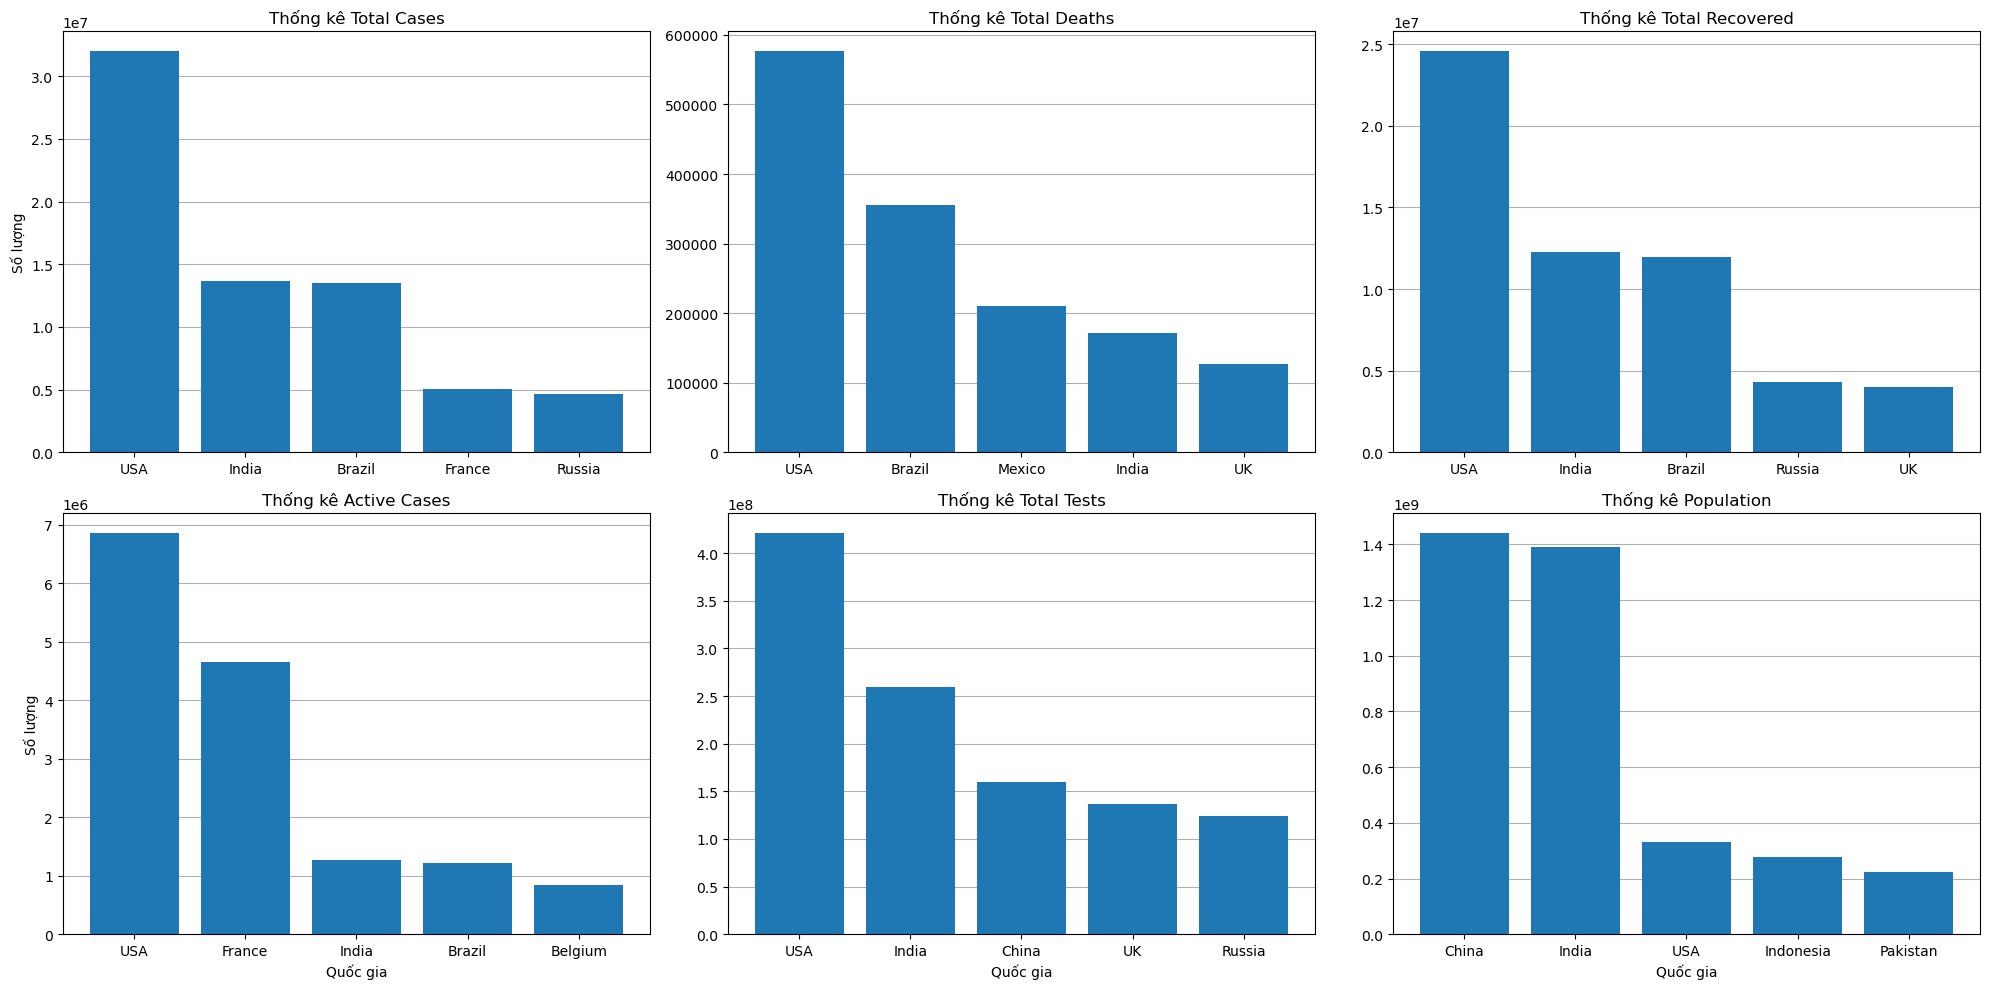

In [46]:
# TODO: draw 6 bar charts
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))

numeric_cols = list(df.columns[1:])
for i, columnName in enumerate(numeric_cols):
    sortedDF = df[['Country Name', columnName]].sort_values(columnName, ascending=False).head(5)
    
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    
    ax.set_title(f'Thống kê {columnName}')
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    ax.bar(sortedDF['Country Name'], sortedDF[columnName])
    if row == num_rows - 1:
        ax.set_xlabel('Quốc gia')
    if col == 0:
        ax.set_ylabel('Số lượng')
    
    
fig.tight_layout()

**TODO**: Comment about the chart

* First, let's look at the tallest columns in each subplot, we can see that `USA` has highest values for every stat (except `Population`). This means that although `USA` is just the country with the third-largest population in the world, their covid situation is the worst: they have the most covid `cases`, `deaths`, `active cases`..., which indicates that their effort to resolve the situation is not very effective. Although the stats `total recovered` and `total tests` are not necessarily bad, but the other stats are still very high, which may imply that those good stats are high just because others are also high (Example: more people infected `cases` might result in more `tests` and more `recovered` occured...).

    These are the consequences of loose pandemic control: most American people don't want to wear the mask while they're supposed to do, most of them are not vaccinated... and the goverment is not very strictly in forcing them to do so, which makes the situation worse. `India` is also a quite similar case but is not as worse as `USA`.

* Second, let's examine the `China` country in our data, we all know that they're the most populous country in the world and also the origin of the pandemic, but they only appear in the top 3 highest `total tests`, which is very good since it shows that their effort in controlling the pandemic is very effective and their people have higher concerned about the virus. I believe that the `total tests` is high while the others are not very significant is a good thing since it may imply that their people care more about the virus so they do the test more frequently to prevent it from spreading as soon as possible.

* There's also an important variable that we shouldn't ignore is `total deaths` which shows how worse the situation is in a country. Except from `USA` that we've just noticed above, the country with second highest `total deaths` is `Brazil` while their `total cases` is just in top 3, this shows us that their death rate is very high, same things also happens for `UK` (may be worse)... 

    These countries should spend more effort on curing the virus to improve the situation: urge people to get vaccinated to decrease the death rate, provide more heathcare services for infected people... Notice that these countries that appeared in the plot may not have the worst death rate but those are pretty significant compared to the others.

### Requirement #3: Draw world map

- Using bar chart just gives you a little bit information about numbers
- In this requirement, you are going to draw a world map with circles which shows the number of cases for each country. Specifically, you are provided a file named `coord.csv` that contains longitude and latitude of each country. You are going to use `Total cases` and `Total Death` to draw the following charts

C:\Users\ngdat\AppData\Local\Temp\ipykernel_17748\1106973127.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


198


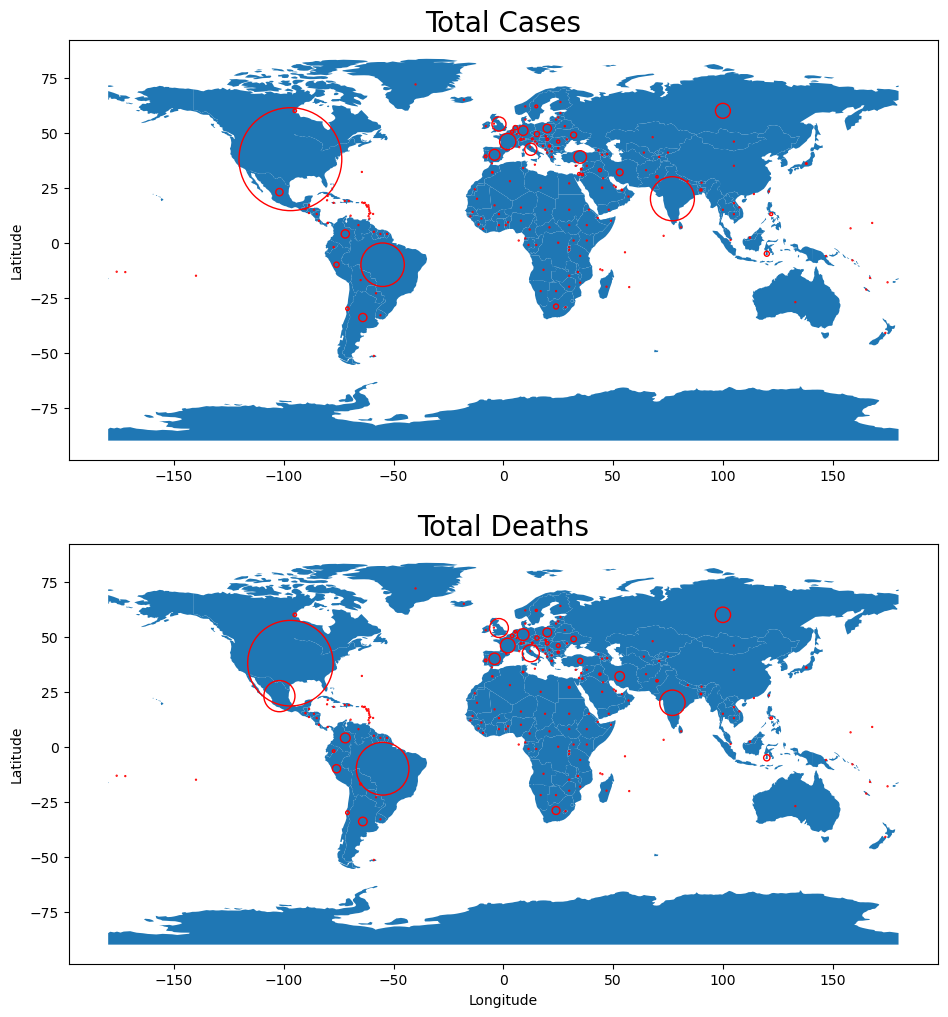

In [47]:
# TODO: draw 2 world map chart using geopandas
coords = None
data = {'Country': None,
        'Latitude': None,
        'Longitude': None}
# read coordinates of all countries
with open('./data/coord.json', 'r') as f:
    coords = json.load(f)
    # re-structure the coordinate data
    data['Country'] = [country for country in coords['lat']]
    data['Longitude'] = [coords['long'][country] for country in coords['long']]
    data['Latitude'] = [coords['lat'][country] for country in coords['lat']]

gdf = geopandas.GeoDataFrame(data)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Plot the world map
fig, axes = plt.subplots(2, 1, figsize=(20, 12))
world.plot(ax=axes[0])
world.plot(ax=axes[1])

# create total cases and deaths lists respective to data['Country']
total_cases = []
total_deaths = []
lats = []
longs = []

for i, country in enumerate(data['Country']):
    indx = df.index[df['Country Name'] == country].to_list()
    if len(indx) != 0: # if appear in both data
        total_cases.append(df['Total Cases'][indx[0]])
        total_deaths.append(df['Total Deaths'][indx[0]])
        lats.append(data['Latitude'][i])
        longs.append(data['Longitude'][i])

totalCasesOfWorld = sum(total_cases)
totalDeathsOfWorld = sum(total_deaths)

# Add circle represent the values on the map
for x, y, cases, deaths in zip(longs, lats, total_cases, total_deaths):
    # scale the number of cases to percentage of total of all countries
    cases = cases / totalCasesOfWorld * 100 
    deaths = deaths / totalDeathsOfWorld * 100
    
    # in case there are some countries with stats that are not significant
    # the min radius is 0.2, which is just enough to draw a dot (indicates the country's location)
    c_radius = max(0.2, cases) 
    d_radius = max(0.2, deaths) 

    c_circle = plt.Circle((x, y), c_radius, color='red', fill=False)
    d_circle = plt.Circle((x, y), d_radius, color='red', fill=False)
    
    axes[0].add_patch(c_circle)
    axes[1].add_patch(d_circle)
    
axes[0].set_title('Total Cases', fontsize=20)
axes[0].set_ylabel('Latitude')

axes[1].set_title('Total Deaths', fontsize=20)
axes[1].set_ylabel('Latitude')
# since these two axes share the same x axis: Longitude, only one label need to be showed
axes[1].set_xlabel('Longitude') 
print(len(total_cases))
# Show the plot
plt.show()

**TODO**: Comment about the chart

* __Total Cases:__ First we can see that there are some countries (`USA`, `India`, `Brazil`...) that have way more cases than the others. _(Note that we've examined this before but we can feel the differences more clearly by look at the differences in size of those circles)_. 

    The pandemic situation in the `North America` continent is the worst with `USA` and `Mexico` are the two outliers which are enough to make the situation in the continent becomes worse. `South America` is also significant since most countries have a noticeable amount of cases. 
    
    By looking at `Europe`, we can see that their situation is also remarkable since almost all countries in `Europe` still suffering from the pandemic. This may be due to the fact that most countries in `Europe` have small territory while having large ammount of cases, which can result in easier spreading makes it harder for their government to control it.

    In `Asia`, the situation is not very bad since most countries have insignificant amount of cases. Except for `India` and `Russia`, these two countries still have many cases due to their large population. However, this don't happen in `China` even when it's the country with the largest population but their number of covid cases is not as large (I've explained this case above).

* __Total Deaths:__ We can see that the same situation that we've analyzed above also happens for `total deaths` variable, this is explainable since more cases often leads to more deaths. Therefore, instead of exmaining the pandemic situation, we will compare the two plots to see if is there any significant difference between `total cases` and `death cases`.

    There are some countries with the number of deaths cases even higher than the number of total cases, these countries include: `Brazil`, `Mexico`, `UK`... Suggesting that the situation is very bad, they should spend more effort on curing and preventing the virus from spreading.

    Although `India` is one of the most populous contries in the world with a huge number of cases, their death rate is rather low (the `total deaths` is smaller than `total cases`). This indicates that their effort on curing and preventing the virus worked very well.

    Moreover, these small red circles in `Africa` don't necessarily show that they have good control on the pandemic, but it may due to their small population leads to fewer cases appear or the imperfection of the data since it's harder to get the accurate data in this continent. 

### Requirement #4: Relationship between 2 variables

- Exploring the relationship between variables is a needed task to do
- You will start with exploring the linear relationship between 2 variables. In order to do so, draw $C_6^2=15$ scatter plots. For each plot, draw a line that shows the linear relationship of variables. You should implement the line yourself instead of using library.

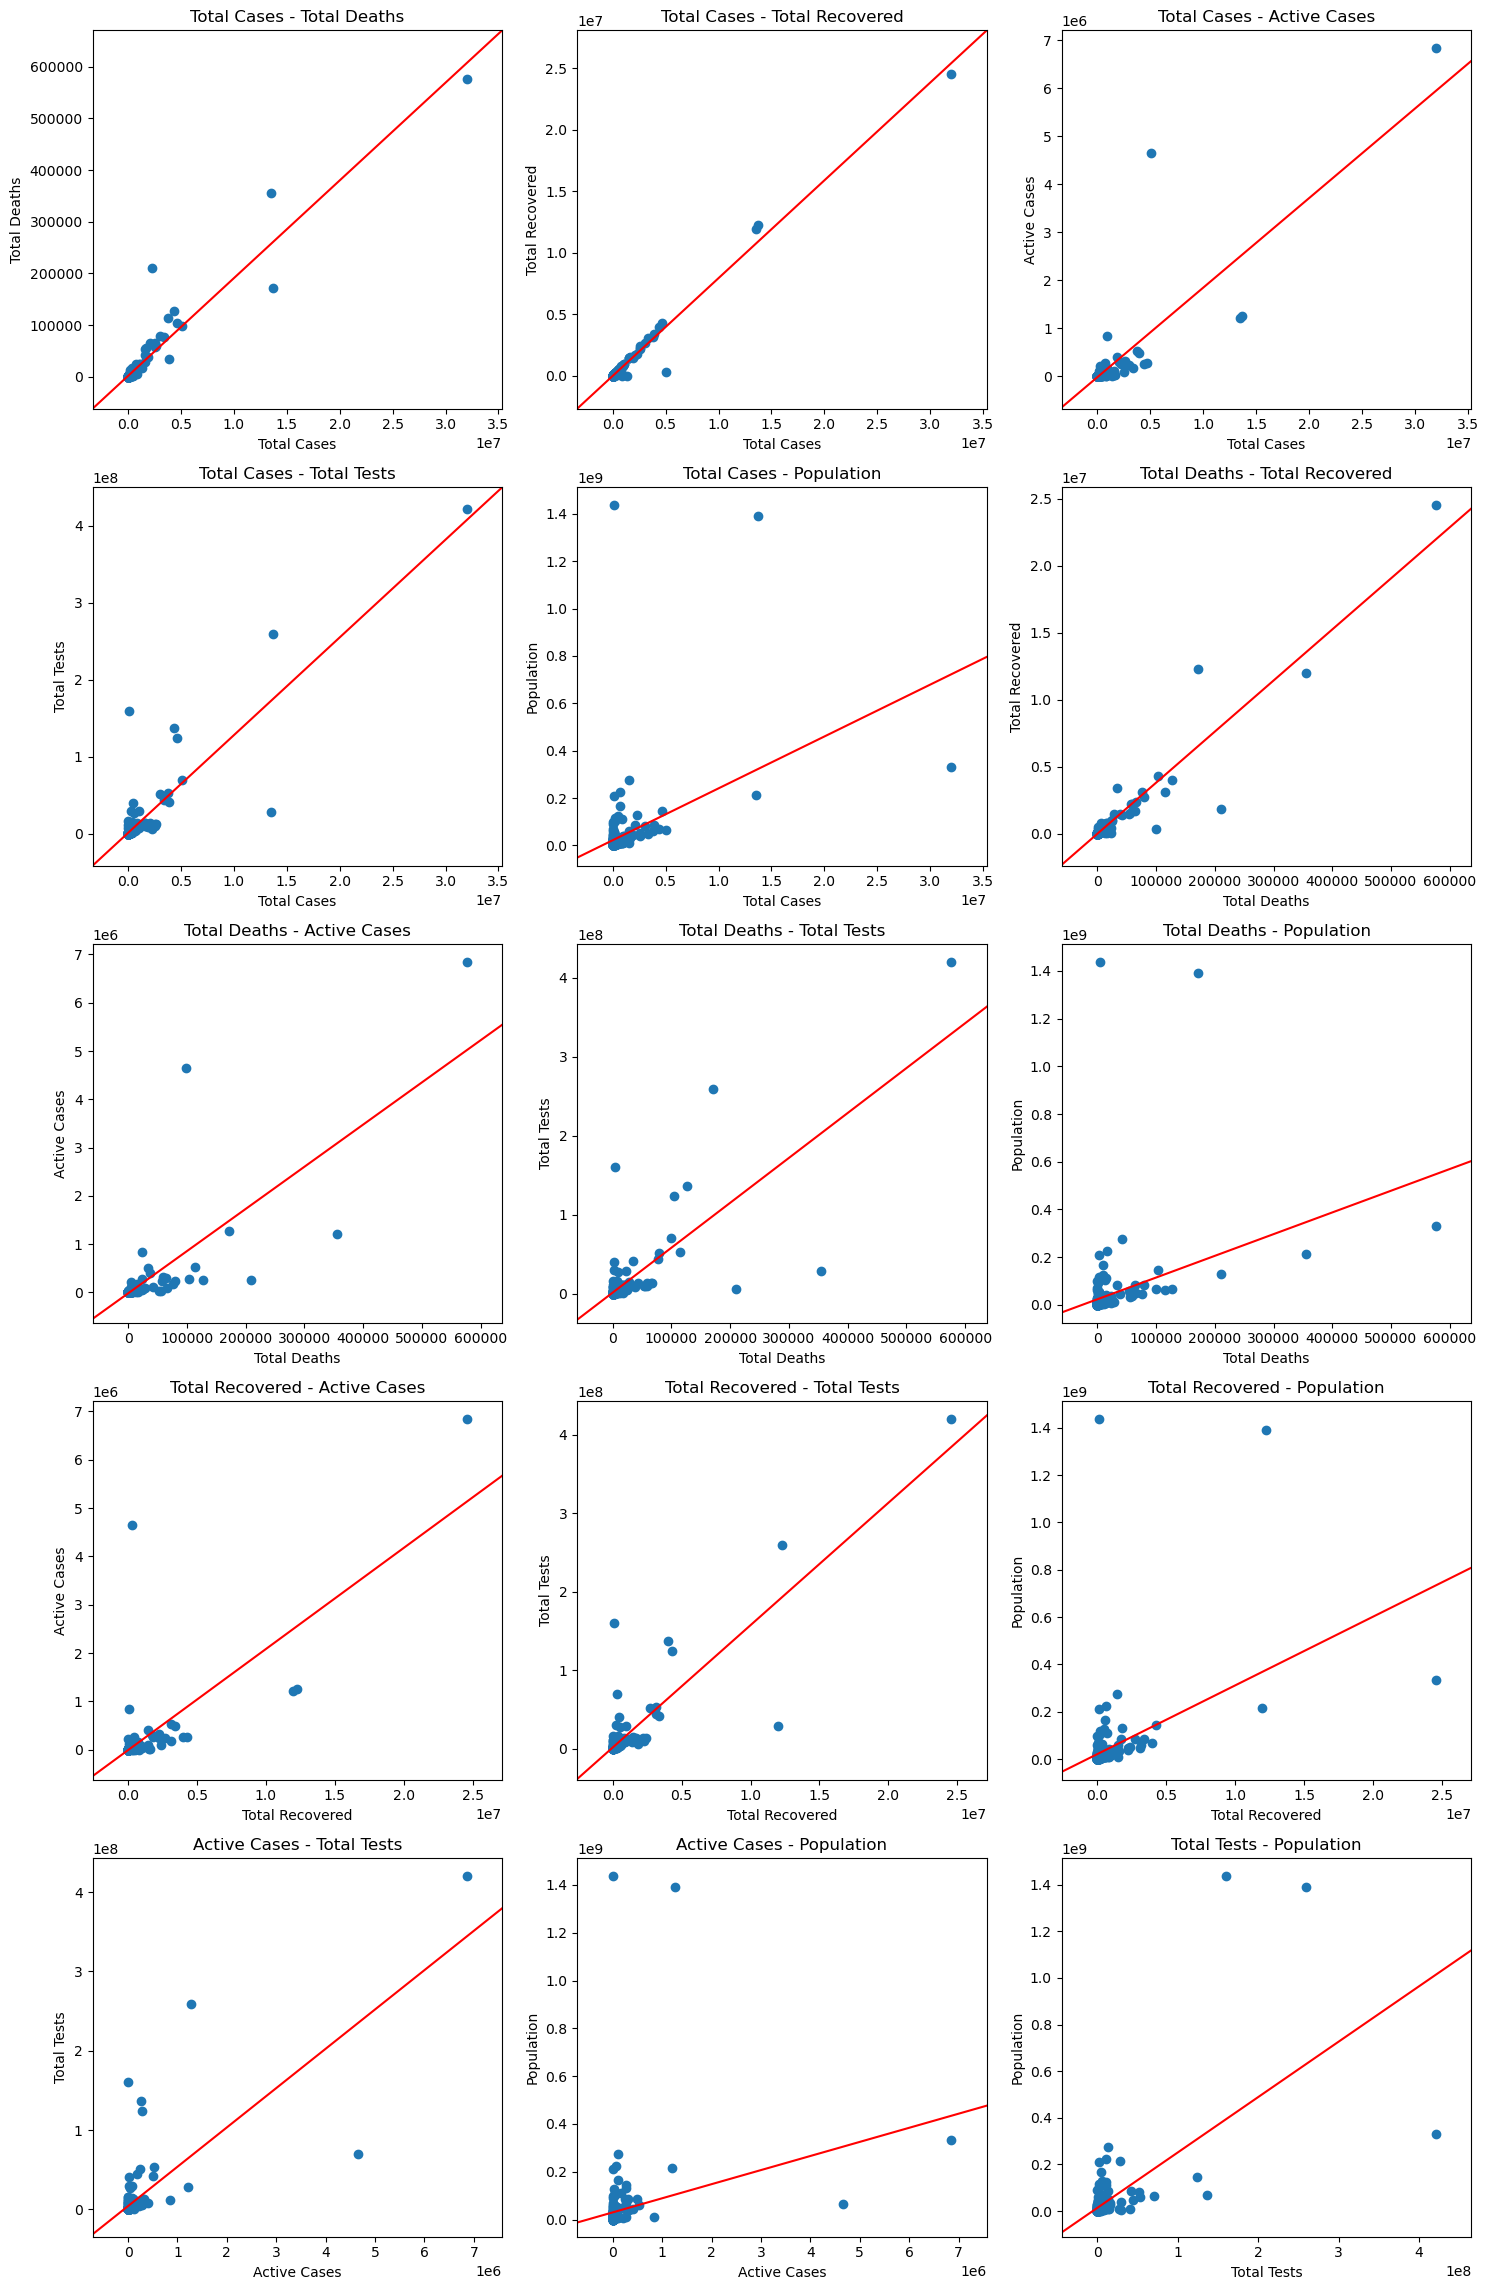

In [48]:
# TODO: scatter stuff

def ordinary_least_squares(x, y):
    """ 
    I'll use the simple OLS method to find the coefficient 
    of the linear equation: y = alpha + beta * x
    """
    # concat the vector one into x (represent beta)
    x = np.concatenate((np.array(x).reshape(-1, 1), np.ones(x.shape).reshape(-1, 1)), axis=1)
    y = np.array(y).reshape(-1, 1) # convert y vector into a column in 2D matrix
    theta = np.linalg.inv(x.T @ x) @ x.T @ y # theta = ((X^T X) ^ -1) X^T y
    return theta[1][0], theta[0][0] # since the result is a column (1x2)

n = len(numeric_cols)

num_cols = 3
num_rows = (n * (n - 1) // 2) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 23))

z = 0
for i in range(n):
    for j in range(i + 1, n):
        i_col = numeric_cols[i]
        j_col = numeric_cols[j]
        
        # determine the row and column position of subplots
        row, col = divmod(z, num_cols)
        ax = axes[row, col]
        
        # draw scatter plot
        ax.scatter(df[i_col], df[j_col])
        ax.set_title(f'{i_col} - {j_col}')
        ax.set_xlabel(i_col)
        ax.set_ylabel(j_col)
        
        # draw the line show the linear relationship
        alpha, beta = ordinary_least_squares(df[i_col], df[j_col])

        # get x limit (left, right) of the ax
        xlim = ax.get_xlim()
        xy1 = (xlim[0], alpha + beta * xlim[0])
        xy2 = (xlim[1], alpha + beta * xlim[1])
        ax.axline(xy1, xy2, color='r')
        
        z += 1
        

fig.tight_layout()

**TODO**: As showed above, give your prediction about the relationship between each pair.

With out the numeric correlation value, we can see how each pair of variables correlate with each other by 2 ways: 

* By looking at the dots on the scatter plot, the more dots converge to the straight line, the stronger relationship between them.
* Or by looking at the red line that I drew on each plot, the closer it is to the identity line (y = x), the stronger linear relationship between them.

I'll group pairs of variables into 4 groups of different linear relationship strength:
* __Very strong relationship:__ This case happens when most dots on the scatter plot converge to the straight line, implies that when a variable increases or decreases, the other also changes in almost the same way. The linear relationship is very strong in this case making it way more easier to predict the future value using the linear model with insignificant errors. The pairs of variables fall into this case include: 
    + `Total Cases - Total Recovered`
    
    + `Total Cases - Total Deaths`
    + `Total Deaths - Total Recovered`
    + `Total Cases - Total Tests`
    + `Total Recovered - Total Tests`

* __Pretty strong relationship:__ There are also some pretty strong relationship between some pairs of variables (but not as impressive as the case above). Although the relationship between them is pronounced and consistent, predicting their values may not be as accurate and remarkable errors may occur. These pairs include:
    * `Total Cases - Active Cases`

    * `Total Deaths - Active Cases`
    * `Total Deaths - Total Tests`
    * `Total Recovered - Active Cases`
    * `Active Cases - Total Tests`
    * `Total Tests - Population`

* __Moderate relationship:__ The relationship between them is still noticeable, but it is not as strong as the above cases. While the relationship is still lightly observable, it might not be as consistent or as powerful. These pairs include:
    * `Total Recovered - Population`

    * `Total Cases - Population`

* __Weak relationship:__ The relationship between them is less pronounced and harder to observe. As one variable increases, the other might increase, but the association is not very weak. Predictions based on a weak correlation are way less reliable.
    * `Total Deaths - Population`
    
    * `Active Cases - Population` 

### Requirement #5: Double check the relationship between 2 variables

- In order to make sure about the linear relationship, you have to check each pair with **Pearson correlation coefficient**
- Specifically, $\rho$ is calculated as follows:

$$\rho_{X, Y} = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

- Then, plot these 15 values using heatmap

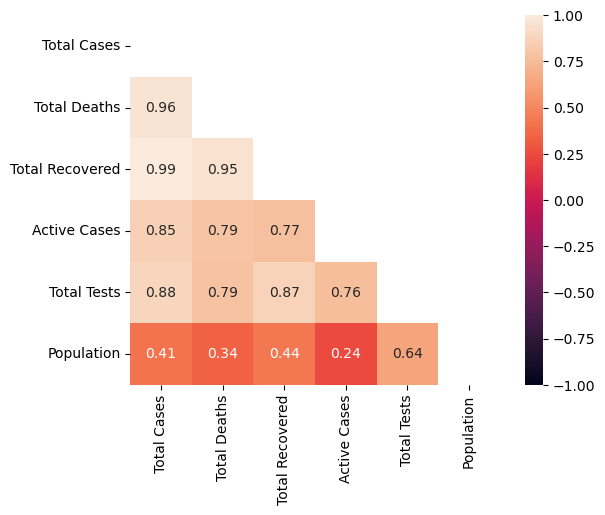

In [49]:
# TODO: create heatamp

def correlation_matrix(df):
    # Initialize an empty correlation matrix
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype='float')
    
    # Fill in the correlation matrix
    for col1 in df.columns:
        for col2 in df.columns:
            cov_xy = np.cov(df[col1], df[col2])[0, 1]
            std_dev_x = np.std(df[col1])
            std_dev_y = np.std(df[col2])
            
            # Calculate correlation using the formula
            correlation = cov_xy / (std_dev_x * std_dev_y)
            
            corr_matrix.loc[col1, col2] = correlation
    return corr_matrix

# notice that it's more accurate to use this method: df.corr('pearson'). 
# after many operations (calculate covariance, std...), the floating point number may not be as accurate

cormatrix = correlation_matrix(df[df.columns[1:]])
mask = np.triu(np.ones_like(cormatrix, dtype=bool)) # for hiding the upper triangle matrix
sn.heatmap(cormatrix, vmin=-1, vmax=1, square=True, annot=True, mask=mask)
# note: seaborn version: 0.12.2 has an error when using annot
# so I updated it with: conda install seaborn
plt.show()

For now, you can check whether your prediction is right or wrong!

With the numeric value (correlation coefficient), it's clearly easier for us to see how strong the relationship between them is. We can groups the relationship into 4 groups based on the value:

* __Very strong correlation (0.8 - 1.0):__ 
    * `Total Cases - Total Recovered` (0.99) (almost perfect)
    
    * `Total Cases - Total Deaths` (0.96)
    * `Total Deaths - Total Recovered` (0.95)
    * `Total Cases - Total Tests` (0.88)
    * `Total Recovered - Total Tests` (0.87)
    * `Total Cases - Active Cases`(0.85)
    
* __Pretty strong correlation (0.6 - 0.8):__ 
    * `Total Deaths - Active Cases` (0.79)

    * `Total Deaths - Total Tests` (0.79)
    * `Total Recovered - Active Cases` (0.77)
    * `Active Cases - Total Tests` (0.76)
    * `Total Tests - Population` (0.64)

* __Moderate correlation (0.4 - 0.6):__ 
    * `Total Recovered - Population` (0.44)

    * `Total Cases - Population` (0.41)

* __Weak correlation (0.2 - 0.4):__ 
    * `Total Deaths - Population` (0.34)

    * `Active Cases - Population`  (0.24)

> => Our prediction about the relationship of each pair using the scatter plot with the linear line above is pretty decent. However, there are also some cases that not as expected since the linear line is not perfect and it must be scaled to be more correct. Moreover, because there are huge differences in most stats between some countries (`USA`, `India`... or _the outliers_) and the others, which makes it way harder for us to predict some variable relationship just by looking at the convergence of the dots in the scatter plot since most of them are gathered in a very small space.

Additional comments and obervations:

Notice that most variables are highly correlated with `Total Cases`, which implies that this variable is useful enough to show how the pandemic situation happens in a country, or it can be used to predict other variables value based on itself.

Moreover, not as we expected, most weaker correlated pairs have the `Population` variable, which may imply that larger population doesn't necessarily result in worse situation, it depends on many factor (government effort, healthcare services, or even the culture...) other than `Population` itself. Or this may be the result of having an outlier in our data: `China`, they are the most populous country in the world but their pandemic situation is well controlled (result in lower values of other variables). 

It's also worth noting that the relationships between all pairs of variables are all __positive__, which implies that no matter which variable changes, all other variables may also change in the same way (increase or decrease); however, the degree of change depends on how large their correlation is.

Additionally, because there are missing values in our data that we must replace them with the median and there're also some countries or regions that do not appear in the coordinate data. Therefore, our analysis may be imperfect or may need to be changed in the future.

## Model visualization

- In this section, we are going to visualize the training and testing process of machine learning model
- The process of training and testing a model is as follow:
    1. Prepare data for training and testing
    2. Create a model
    3. Train and test the model
    4. Visualize the result

- You are required to:
    1. Study Multi-layer neural network and Convolutional neural network
    2. Study `Pytorch` in order to prepare data and design machine learning model
    3. Design 2 models to classify MNIST dataset. Then, visualize the result of each model and compare the result to each other
        - Model 1: A fully-connected model with 4 layers. The input layer has $784$ neurons. The hidden layer #1 has $1024$ neurons, which is followed by a $ReLU$ as activation functions. The hidden layer #2 has $512$ neurons, also followed by a $ReLU$ as activation functions. The output layer has $10$ neurons (of course), which follows by a $LogSoftmax$ function
        - Model 2: A CNN model with 2 Convolution layers and 1 linear layer. All the CNN layers have 20 filters, kernel size equal to $5$. Each of them is followed by a $ReLU$ activation function and a MaxPooling2D layer ($kernel\_size=2$). The linear layer is followed by a $LogSoftmax$ activation function

- Google Colab can be used since it provides free GPU, which makes your training and testing process faster

### Requirement #6: Prepare data

- `Pytorch` supports a lot of datasets for running machine learning model. In this lab, we use MNIST dataset. So, download the training set and the testing set using `Pytorch` and store them in `./data`
- Note that you have to transform your data into `tensor` (a datatype that's quite similar to `numpy array`) so you can input to model
- After that, create `train_dataloader` and `test_dataloader`

**TODO**: Explain why we have to create dataloader

- __Batch Processing__: Dataloader can do batch processing which is more memory-efficient than processing the entire dataset at once, especially when dealing with large datasets that may not fit into memory.

- __Shuffle__: For training, shuffling the data in each epoch helps the model generalize better by preventing it from learning patterns based on the order of the examples (prevent overfitting).

- __Convenience and Efficiency__: Dataloaders provide a convenient way to load and process data in parallel, taking advantage of multi-core processors (of the GPU).

In [50]:
# TODO: download training, testing data and store them into training_data and testing_data
# Then, create train_dataloader and test_dataloader with batch_size=32

# Download
train_dataset = datasets.MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=ToTensor(), download=True)

# Set batch size
BATCH_SIZE = 32

# Create data loaders
# train
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test (shuffle is optional)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False) 

- After downloading the data, visualize 10 random samples (2 rows, 5 samples for each row) from training set.

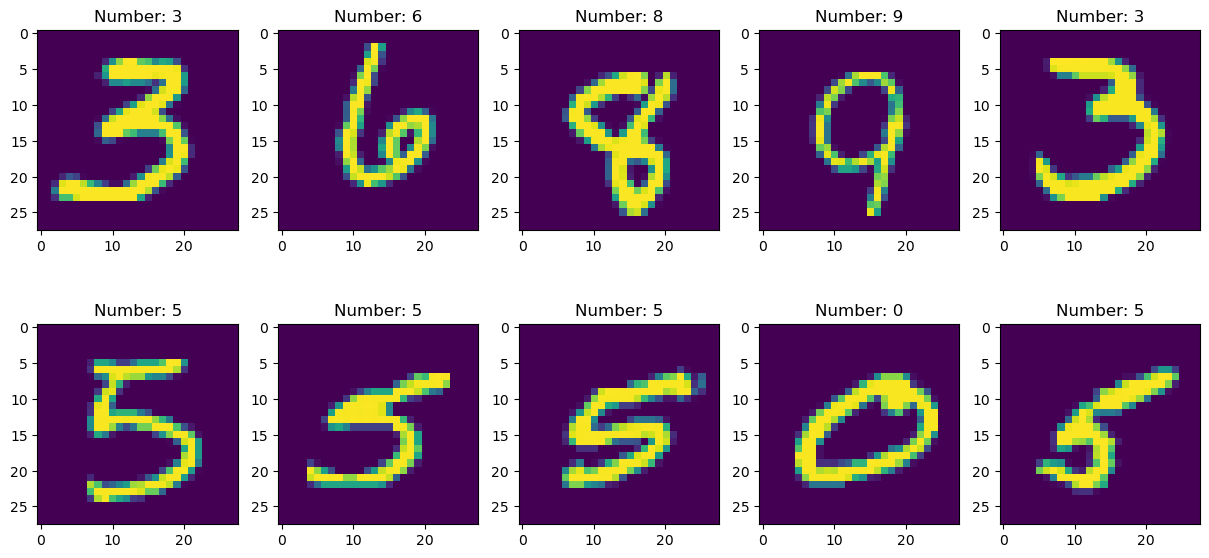

In [51]:
# TODO: visualize 10 random samples

# fixed result
torch.manual_seed(240)

num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))


for i in range(num_cols * num_rows):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    ax.set_title(f'Number: {label}')
    ax.imshow(img.squeeze())


### Requirement #7: Create models

- Create 2 models as mentioned above. Call them `Mnist_FC` and `Mnist_CNN`
- **I strongly recommend that you should slowly implement, print out the output and its shape of each layer in order to get a deep understanding of what you are trying to do**
- Before moving to the next requirement, you should test your model with a random sample of the dataset. In case you create code cells for testing, remember to remove these cells

In [52]:
# TODO: create Mnist_FC and Mnist_CNN

# - Model 1: A fully-connected model with 4 layers.
class Mnist_FC(nn.Module):
    def __init__(self):
        super(Mnist_FC, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(), # flatten input before linear layer
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


# - Model 2: A CNN model with 2 Convolution layers and 1 linear layer.
class Mnist_CNN(nn.Module):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(20, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(), # flatten input before linear layer
            nn.Linear(320, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


### Requirement #8: Train and test models

- Design `train` and `test` function with the parameters provided in the following code cell
    - `train` function trains the model with all the data in training set
    - `test` function tests the model with all data in testing set

- Return the accuracy (e.g. $0.847351$) after training and testing

**TODO**: Explain the parameters of `train` and `test` function. In `test` function, there is a line of code that says `with torch.no_grad()`. Why do we have this line of code?

Parameters:
- __dataloader:__ is a utility that helps efficiently load and iterate over our dataset (that we just created above: it can be `train_dataloader` or `test_dataloader`). It creates batches of data that are fed into the model.

- __model:__ refers to the neural network architecture that we are training or testing (it can be `Mnist_FC` or `Mnist_CNN` that we created above). It represents the mathematical model that learns patterns by training and makes predictions based on input data on the test set.

- __loss_fn:__ measures the degree of dissimilarity of the model's predictions to the actual target values. The model will try to make this loss as small as possible by modifying some parameters after each epoch.

- __optimizer:__ is an algorithm that instructs the model how to its parameters to minimize loss. By updating the weights or biases of the model based on the gradients of the loss function with respect to those parameters (back propagating).



Why we need `torch.no_grad()`: By default, all tensors (are often weights and biases) with `requires_grad=True` are tracking their computational history and support gradient computation. However, for testing model, we do not need to do that and we only want to do _forward_ computations through the network. 

Calling the method `torch.no_grad()` can stop tracking computations, which helps reduce memory and time cost (since we only doing forward pass and computations on tensors that do not track gradients are more efficient). Moreover, this help mark some parameters in our neural network as _frozen parameters_, which is a very common scenario for fine tuning a pre-trained network.

Note: we can also use the `.detach()` method for the same purpose.

In [53]:
# TODO: design train and test function

# check gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} for training and testing')

def train(dataloader, model, loss_fn, optimizer):
    global device 
    size = len(dataloader.dataset)
    correct = 0
    
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X.cuda() if device == 'cuda' else X)
        y = y.cuda() if device == 'cuda' else y
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct / size

def test(dataloader, model):
    global device
    
    size = len(dataloader.dataset)
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.cuda() if device == 'cuda' else X)
            y = y.cuda() if device == 'cuda' else y
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return correct / size

Using cuda for training and testing


- Run 20 epochs for each model. In order to do so, at fist, you have to define `learning_rate, loss_fn` and `optimizer`. I will help you on that

- Save the history of training and testing process as `history_fc` and `history_cnn`. During the running process, you should print out the accuracy in order to keep track

- The history is a dictionary with the following structure:

```python
history = {
    1: [0.6, 0.5], # the key (type: int) is the epoch
    2: [0.7, 0.6], # the value (type: list) contains the accuracy of training and testing process at the corresponding epoch
    ...
}
```

**TODO**: List out some loss functions and optimizers that you have heard about

__Loss functions:__

- _Mean Squared Error (MSE)_: it calculates the average of the squared differences between predicted and actual values, it's often used for regression tasks.

- _Huber Loss_: A combination of MSE and Mean Absolute Error (MAE), it is less sensitive to outliers than MSE.

- _Binary Cross-Entropy Loss_: Commonly used for binary classification problems (which is not suitable for our problem), it measures the cross-entropy between predicted and true labels.

- _Categorical Cross-Entropy Loss_: Suitable for multi-class classification problems (suitable for our problem), it measures the cross-entropy between predicted probabilities and true one-hot encoded class labels.

- _Hinge Loss_: Often used in support vector machines and for binary classification, it encourages correct classification of training data points.


__Optimizers:__
- _Stochastic Gradient Descent (SGD)_: The algorithm that updates model parameters in the direction opposite to the gradient of the loss function. It's a process that searches for an objective function’s optimum value (Minimum/Maximum) starting with a random sample.

- _RMSprop_: Root Mean Square Propagation adjusts the learning rates for each parameter based on the average of the recent magnitudes of the gradients.

- _Adam_: An adaptive learning rate optimization algorithm that combines ideas from _RMSprop_ and _Momentum_. It is widely used due to its effectiveness in a variety of tasks.

- _Nadam_: An extension of Adam that incorporates Nesterov accelerated gradient into its updates.

- _Adagrad_: Adapts the learning rate for each parameter based on the historical gradients. It performs well in sparse data scenarios (which is not our case).

In [54]:
# TODO: run 20 epochs for Mnist_FC and Mnist_CNN
def process(model_class, epochs, loss_fn, learning_rate, optimizer_class):
    history = {}
    global device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model_class().to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    for t in range(epochs):
        train_acc = train(train_dataloader, model, loss_fn, optimizer)
        test_acc = test(test_dataloader, model)
        history[t + 1] = [train_acc, test_acc]
        print(f"\nEpoch {t+1}\n-------------------------------")
        print(f'Training acc: {train_acc:.3f}')
        print(f'Testing acc: {test_acc:.3f}')
    return history
    
epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD
print('========== FC model ==========')
history_fc = process(Mnist_FC, epochs, loss_fn, learning_rate, optimizer)


print('========== CNN model ==========')
history_cnn = process(Mnist_CNN, epochs, loss_fn, learning_rate, optimizer)

========== FC model ==========



Epoch 1
-------------------------------
Training acc: 0.341
Testing acc: 0.639

Epoch 2
-------------------------------
Training acc: 0.703
Testing acc: 0.740

Epoch 3
-------------------------------
Training acc: 0.749
Testing acc: 0.786

Epoch 4
-------------------------------
Training acc: 0.804
Testing acc: 0.830

Epoch 5
-------------------------------
Training acc: 0.836
Testing acc: 0.849

Epoch 6
-------------------------------
Training acc: 0.855
Testing acc: 0.870

Epoch 7
-------------------------------
Training acc: 0.869
Testing acc: 0.880

Epoch 8
-------------------------------
Training acc: 0.878
Testing acc: 0.888

Epoch 9
-------------------------------
Training acc: 0.885
Testing acc: 0.892

Epoch 10
-------------------------------
Training acc: 0.890
Testing acc: 0.895

Epoch 11
-------------------------------
Training acc: 0.893
Testing acc: 0.899

Epoch 12
-------------------------------
Training acc: 0.896
Testing acc: 0.902

Epoch 13
---------------------------

### Requirement #9: Visualize

- Produce a graph as the following code cell and comment about the running process of 2 models

**TODO**: Your comment

- __Training Accuracy:__ The accuracy starts from a lower value and gradually improves over epochs. However, it still reaches a high accuracy of by the end of training.

- __Testing Accuracy:__ The testing accuracy follows a similar trend, starting from a lower value and reaching a nearly the same accuracy by the end of training.

- __Comparison to Training Accuracy:__ The testing accuracy closely tracks the training accuracy, suggesting good generalization. Moreover, it's remarkable that the accuracy on the testing set mostly higher than its counterpart, this may indicate that our models don't encounter the overfitting problem.

- __Observations:__ The lower initial accuracy may indicate that the model struggles to capture patterns in the data early on but improves with training.

- __Performance:__ Both models exhibit a clear improvement in accuracy over epochs, suggesting that the models are learning and adapting to the training data. Moreover, the CNN model shows a substantial improvement compared to FC model, highlighting the power of convolutional layers in capturing spatial features in image data.

- __Learning Rate, Loss Function, and Optimizer:__ The choice of a learning rate of 0.001, `nn.CrossEntropyLoss()` loss function, and SGD optimizer seems effective, as the models are converging well and achieving decent accuracies.

- __Potential for Further Optimization:__ While the models are performing well, there might still be room for further hyperparameter tuning or architectural adjustments to enhance performance. 

    Example: it's more suitable to use the `nn.NLLLoss()` loss function since we used the Log softmax for the final layer. And `Adam` is also a good optimizer for this case. Increasing the number of epochs is also a straight-forward solution but may result in more time cost and the risk of overfitting.

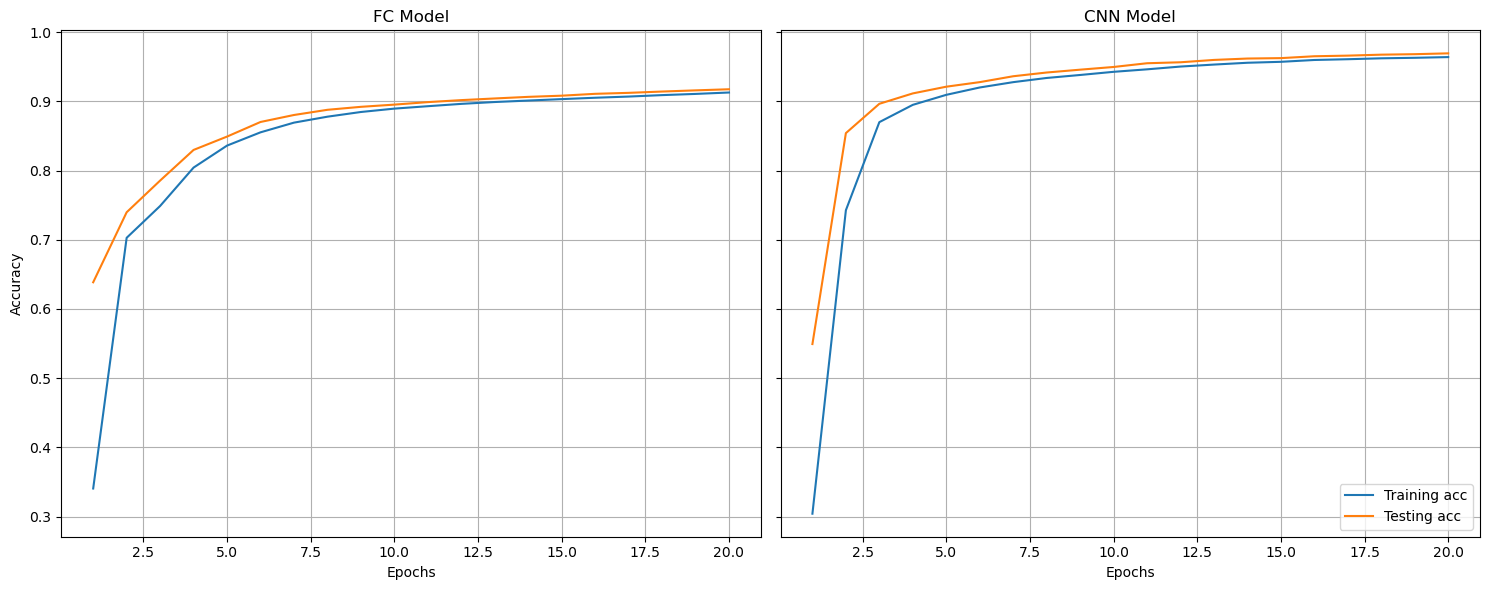

In [55]:
# TODO: visualize the history
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

x = list(history_fc.keys())

y_train_fc = []
y_test_fc = []
y_train_cnn = []
y_test_cnn = []
for t in history_fc.keys():
    y_train_fc.append(history_fc[t][0])
    y_test_fc.append(history_fc[t][1])
    
    y_train_cnn.append(history_cnn[t][0])
    y_test_cnn.append(history_cnn[t][1])
    
axes[0].set_title("FC Model")
axes[0].plot(x, y_train_fc, color='tab:blue', label='Training acc')
axes[0].plot(x, y_test_fc, color='tab:orange', label='Testing acc')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].grid()

axes[1].set_title("CNN Model")
axes[1].plot(x, y_train_cnn, color='tab:blue', label='Training acc')
axes[1].plot(x, y_test_cnn, color='tab:orange', label='Testing acc')
axes[1].set_xlabel('Epochs')
axes[1].grid()

axes[1].legend(loc='lower right')

fig.tight_layout()

- Highly recommend you go play around with the parameters of models and re-implement 2 models using `TensorFlow` using Colab